In [2]:
import pandas as pd
import datetime as dt
import time
from os import listdir
from os.path import isfile, join
import numpy as np

In [3]:
folder = "/Users/aronnyberg/code/quanty2/gateio_data/major_trade_data"
files = [f for f in listdir(folder) if isfile(join(folder, f))]

In [4]:
#files = [i for i in files if i[6] in ['202307', '202308', '202309']]


['SOL_USDT-202204',
 'SOL_USDT-202009',
 'SOL_USDT-202203',
 'SOL_USDT-202007',
 'SOL_USDT-202006',
 'SOL_USDT-202202',
 'SOL_USDT-202205',
 'SOL_USDT-202008',
 'SOL_USDT-202111',
 'SOL_USDT-202110',
 'SOL_USDT-202104',
 'SOL_USDT-202103',
 'SOL_USDT-202301',
 'SOL_USDT-202306',
 'SOL_USDT-202102',
 'SOL_USDT-202105',
 'SOL_USDT-202012',
 'SOL_USDT-202211',
 'SOL_USDT-202210',
 'SOL_USDT-202207',
 'SOL_USDT-202209',
 'SOL_USDT-202208',
 'SOL_USDT-202206',
 'SOL_USDT-202201',
 'SOL_USDT-202112',
 'SOL_USDT-202107',
 'SOL_USDT-202303',
 'SOL_USDT-202109',
 'SOL_USDT-202304',
 'SOL_USDT-202108',
 'SOL_USDT-202305',
 'SOL_USDT-202302',
 'SOL_USDT-202106',
 'SOL_USDT-202101',
 'SOL_USDT-202011',
 'SOL_USDT-202212',
 'SOL_USDT-202010']

In [6]:
def date_processing(df):
    df = df[["timestamp","dealid","price","amount","side"]]
    df['hour'] = [i[:-3] for i in df['timestamp']]#.apply(lambda x: x.strftime('%Y-%m-%d-%H'))
    df.set_index("hour", inplace=True)
    df.sort_values(by='timestamp', inplace=True)
    return df

def vwap1():
    df = pd.DataFrame()
    for each_file in files[:1]:
            if each_file != ".DS_Store":
                #vwap calc based on https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday
                tp = (each_file['price'].groupby(level=0).max()+each_file['price'].groupby(level=0).min()
                    +each_file['price'].groupby(level=0).tail(1))/3
                v = each_file['amount'].groupby(level=0).sum()
                tp_v = tp*v
                tp_v_cum = tp_v.cumsum()
                v_cum = v.cumsum()
                vwap = tp_v_cum/v_cum
                new_df = pd.DataFrame(vwap)
                new_df['ticker'] = each_file[:-7]
                new_df.columns = ['vwap', 'ticker']
                if df.empty:
                    df = new_df
                else: 
                    df = pd.concat([df, new_df])
    #df.to_csv("/Users/aronnyberg/code/quanty2/data/aggregated_trade_data.csv")
    return df

def vwap_vanilla(df):
    q = df.amount.values
    p = df.price.values
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())

def vwap2(df):
    df = df.groupby(df.index.date, group_keys=False).apply(vwap_vanilla)
    return df

In [7]:
# each = files[:1][0]
# df = pd.read_csv(folder+"/"+each)
# df = df[["timestamp","dealid","price","amount","side"]]
# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d-%H-%M')
# df.sort_values('timestamp', inplace=True)
# df.set_index('timestamp', inplace=True)

In [8]:
def each_assetmonth_sort(each_assetmonth):
    #read and sort each month of data
    df = pd.read_csv(folder+"/"+each_assetmonth)
    df = df[["timestamp","dealid","price","amount","side"]]
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d-%H-%M')
    df.sort_values('timestamp', inplace=True)
    df.set_index('timestamp', inplace=True)
    #calculate vwap
    df = vwap2(df)
    #assemble all assets and times together
    df = df[['price', 'vwap']]
    #df['vwap_pct_change'] = df['vwap'].pct_change()
    #df['price_pct_change'] = df['price'].pct_change()
    df['ticker'] = each_assetmonth[:-7]
    return df

batched_data =[]
for files in 
for each_assetmonth in files:
        if each_assetmonth != ".DS_Store":
              batched_data.append(each_assetmonth_sort(each_assetmonth))

            


# [i.split('-')[0] for i in files]
# matching_files = [i for i in listdir(folder) if isfile(join(folder,i)) and \
#          'SFP_USDT' in i]
# matching_files

/var/folders/jq/bnrgxd_s43d7nggw471h_rtm0000gn/T/ipykernel_26924/2966718904.py:33: RuntimeWarning: invalid value encountered in divide
  return df.assign(vwap=(p * q).cumsum() / q.cumsum())
/var/folders/jq/bnrgxd_s43d7nggw471h_rtm0000gn/T/ipykernel_26924/2966718904.py:33: RuntimeWarning: invalid value encountered in divide
  return df.assign(vwap=(p * q).cumsum() / q.cumsum())
/var/folders/jq/bnrgxd_s43d7nggw471h_rtm0000gn/T/ipykernel_26924/2966718904.py:33: RuntimeWarning: invalid value encountered in divide
  return df.assign(vwap=(p * q).cumsum() / q.cumsum())


In [ ]:
agg_df = pd.concat(batched_data)

: 

In [ ]:
agg_df.head()

In [ ]:
agg_df.to_csv("/Users/aronnyberg/code/quanty2/gateio_data/majors_agg_trade_data.csv")

,price,vwap,ticker
timestamp,,,
2023-07-01 01:01:00,2.3950,2.395000,ASR_USDT
2023-07-01 01:02:00,2.3945,2.394754,ASR_USDT
2023-07-01 01:03:00,2.3964,2.395419,ASR_USDT
2023-07-01 01:04:00,2.3937,2.394892,ASR_USDT
2023-07-01 01:05:00,2.3986,2.395194,ASR_USDT
...,...,...,...
2023-09-01 00:55:00,1.8469,1.855185,INTER_USDT
2023-09-01 00:56:00,1.8491,1.855055,INTER_USDT
2023-09-01 00:57:00,1.8562,1.855074,INTER_USDT


In [14]:
#specific processing
#agg_df = pd.read_csv("/Users/aronnyberg/code/quanty2/gateio_data/btc_trade_data.csv")


In [21]:
# agg_df = agg_df[agg_df['ticker'] =="BTC_USDT"]
agg_df['timestamp'] = pd.to_datetime(agg_df['timestamp'])
agg_df.set_index('timestamp', inplace=True)
agg_df = agg_df['vwap']

In [22]:
batch_size = 100000  # Number of data points per batch

# Calculate the number of batches
num_batches = len(agg_df) // batch_size

# Initialize an empty list to store the batched data
batched_data = []

# Loop through the data and create batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch = agg_df.iloc[start_idx:end_idx]
    # Here, you can perform any desired aggregation on the batch, e.g., sum, mean, etc.
    batched_data.append(batch.pct_change().resample('T').sum())

In [23]:
# Concatenate the batched data into a single DataFrame
#daily_btc_rets = pd.concat(batched_data)
daily_rets = pd.concat(batched_data)

In [24]:
daily_rets = daily_rets.resample('T').sum()

<AxesSubplot:xlabel='timestamp'>

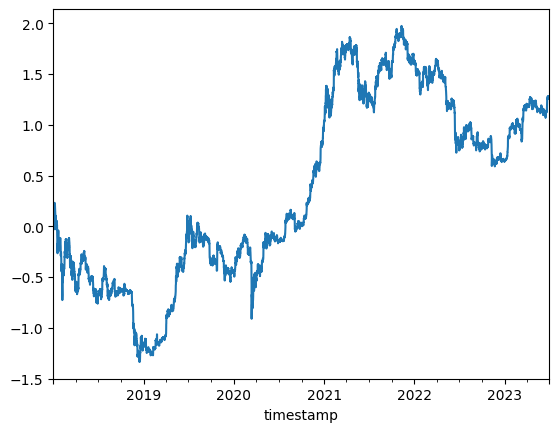

In [27]:
daily_rets.cumsum().plot()

In [12]:
pd.concat(batched_data[:10])

,price,vwap,ticker
timestamp,,,
2022-04-01 01:00:00,122.81810,122.818100,SOL_USDT
2022-04-01 01:00:00,123.02600,122.936900,SOL_USDT
2022-04-01 01:00:00,123.14590,122.960946,SOL_USDT
2022-04-01 01:00:00,123.11970,122.980734,SOL_USDT
2022-04-01 01:00:00,123.02940,122.987953,SOL_USDT
...,...,...,...
2022-06-01 00:59:00,0.08433,0.083727,TRX_USDT
2022-06-01 00:59:00,0.08432,0.083727,TRX_USDT
2022-06-01 00:59:00,0.08435,0.083727,TRX_USDT
